# Equity Analyst Agent with Assistants API

### This notebook showcases the capabilities of Azure OpenAI's Assistants API for an Equity Analyst Agent. 

Install the necessary Python packages (openai, matplotlib, tenacity, python-dotenv) for the notebook to function.

In [1]:
%pip install openai matplotlib tenacity python-dotenv

Note: you may need to restart the kernel to use updated packages.


Imports the necessary Python modules and classes used in the notebook. Note the openai module is used to interact with the Assistants API.

In [1]:
import io
import os
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Iterable
from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile

### Environment Configuration
This cell is crucial for setting up the environment configuration necessary for the notebook to interact with Azure OpenAI. 

- **Requirement**: Ensure that a `.env` file exists in the same directory as this notebook. This file should contain the necessary API credentials and configuration details, which you can obtain from https://ai.azure.com 
- **Keys in .env File**: The `.env` file must include the following keys:
  - `OPENAI_ENDPOINT`: The endpoint URL for the Azure OpenAI service.
  - `OPENAI_API_KEY`: Your API key for accessing Azure OpenAI services.
  - `OPENAI_MODEL_NAME`: The name of the specific Azure OpenAI model you intend to use.


In [2]:
load_dotenv(".env")
api_endpoint = os.getenv("OPENAI_ENDPOINT")
api_key = os.getenv("OPENAI_API_KEY")
api_deployment_name = os.getenv("OPENAI_MODEL_NAME")
api_version = "2024-02-15-preview"

### Initializing Azure OpenAI Client

Initializes `AzureOpenAI` client with necessary credentials and configurations:
- `api_key`: API key for authentication.
- `api_version`: Targeted API version, set to `"2024-02-15-preview"`.
- `azure_endpoint`: Endpoint URL for Azure OpenAI services.

This step is crucial for establishing communication with Azure OpenAI services.


In [3]:
client = AzureOpenAI(api_key=api_key, 
                     api_version=api_version, 
                     azure_endpoint=api_endpoint)

### Create the assistant with tools

In [4]:
tools_list = [{"type": "code_interpreter"}]

In [5]:
DATASETS = "datasets/"

def upload_file(client: AzureOpenAI, path: Path) -> FileObject:
    with path.open("rb") as f:
        return client.files.create(file=f, purpose="assistants")

assistant_files = [upload_file(client, Path(DATASETS) / file) for file in os.listdir(DATASETS)]
file_ids = [file.id for file in assistant_files]

In [6]:
assistant = client.beta.assistants.create(
    name="Equity Analyst",
    instructions=("You are an equity analyst that performs analysis on the given datasets. "
                  "Use the provided file only."),
    tools=tools_list,
    model=api_deployment_name,
    file_ids=file_ids,
)

thread = client.beta.threads.create()

In [7]:
def format_messages(messages: Iterable[MessageFile]) -> None:

    message_list = []

    # Iterate through the messages and break when a user message is encountered
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the list of messages
    message_list = message_list[::-1]

    for message in message_list:
        for item in message.content:
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                try:
                    response_content = client.files.content(item.image_file.file_id)
                    data_in_bytes = response_content.read()
                    readable_buffer = io.BytesIO(data_in_bytes)
                    image = plt.imread(readable_buffer, format='jpeg')
                    plt.imshow(image)
                    plt.axis('off')
                    plt.show()
                except Exception as e:
                    print(f"Exception: {e}")

In [8]:
from tenacity import retry, stop_after_attempt, wait_exponential, RetryError, retry_if_exception_type

# Custom exception for specific retry condition
class NotCompletedException(Exception):
    pass

@retry(stop=stop_after_attempt(15), 
       wait=wait_exponential(multiplier=1.5, min=4, max=20),
       retry=retry_if_exception_type(NotCompletedException))
def check_run_status(thread_id, run_id):
    run = client.beta.threads.runs.retrieve(thread_id=thread_id, run_id=run_id)
    if run.status in ["completed", "failed", "expired", "cancelled"]:
        return run
    elif run.status == "requires_action":
        # Handle cases that require action differently
        # For example, you might not want to retry in this case
        pass
    else:
        # This will cause a retry for statuses not explicitly handled above
        raise NotCompletedException("Run not completed yet")

def process_message(content: str):
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions=f"You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools.",
    )

    try:
        run = check_run_status(thread.id, run.id)
        messages = client.beta.threads.messages.list(thread_id=thread.id)
        format_messages(messages)
    except RetryError:
        print("Operation failed or timed out after maximum retries.")
    except NotCompletedException:
        print("Operation did not complete in the expected status.")


### Have the model perform a DCF valuation

user:
List out the values in CSV and visualize it

assistant:
First, I will load the CSV file that you uploaded to check its contents. Then I will list out the values for you to see, and finally, I will visualize the data using appropriate visualizations based on the type of the data present in the CSV file.

I will start by loading the CSV file and displaying the first few rows to understand its structure and contents. Let's begin with that.

assistant:
The CSV file contains financial projections, including:

- `Year`: The fiscal year for the projection.
- `Projected Revenue`: The expected revenue for the company in that year.
- `Projected EBIT`: Earnings Before Interest and Taxes projected for that year.
- `Projected Net Income`: The company's projected net income for that year.
- `Projected Free Cash Flow`: The projected free cash flow for the company in that year.
- `Discount Factor`: The factor used to discount future cash flows to their present value.
- `Present Value of FCF`: Th

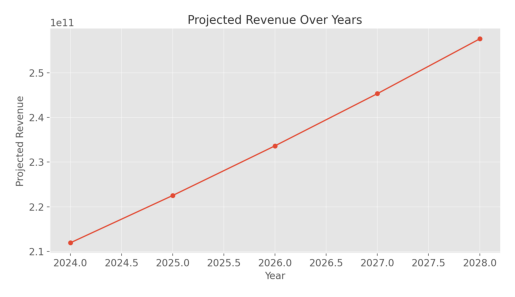

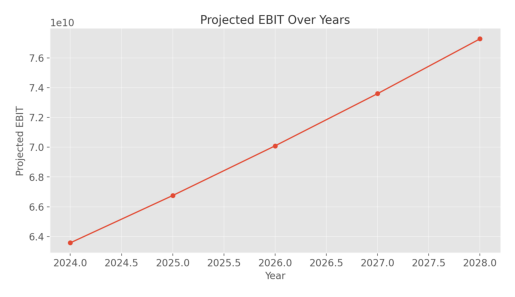

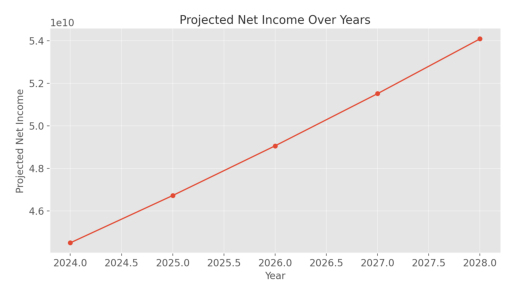

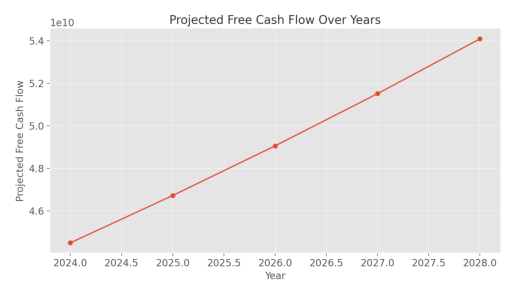

assistant:
Here are the visualizations for the given projections:

1. **Projected Revenue Over Years**: This line plot shows the trend for the company's projected revenue over the years.
2. **Projected EBIT Over Years**: This line plot illustrates the trend for the company's projected Earnings Before Interest and Taxes (EBIT) over the years.
3. **Projected Net Income Over Years**: This visualization presents the trend for the company's projected net income over the years.
4. **Projected Free Cash Flow Over Years**: This plot depicts the trend of the company's projected free cash flow over the years.

Each of these projections increases over time, indicating that the company expects growth in these financial metrics year after year.



In [9]:
process_message("List out the values in CSV and visualize it")

In [10]:
process_message("Create and execute python code to perform a discounted cash flow valuation using the given data in csv. Make generic assumptions")

user:
Create and execute python code to perform a discounted cash flow valuation using the given data in csv. Make generic assumptions

assistant:
To perform a discounted cash flow (DCF) valuation using the provided data, we need to follow these steps:

1. **Estimate the Free Cash Flows (FCFs)**: We will use the 'Projected Free Cash Flow' column from the data.

2. **Calculate the Present Value of Future Cash Flows**: We will discount the FCFs using the 'Discount Factor' to get the present value of each year's FCF.

3. **Calculate Terminal Value**: We need to estimate the value of the company's cash flows beyond the projection period. A common approach is to apply a perpetuity growth model using the last projected FCF and a perpetuity growth rate. I will assume a generic perpetual growth rate of 2.5%.

4. **Calculate the Present Value of Terminal Value**: We need to discount the terminal value back to its present value.

5. **Calculate Equity Value**: We sum the present values of the pr

user:
Visualize this information

assistant:
Certainly! A good way to visualize this discounted cash flow (DCF) valuation is by creating a bar chart that represents the present value of projected free cash flows, the present value of the terminal value, and the total present value (equity value). 

Let's create a bar chart where each bar represents one of these components:



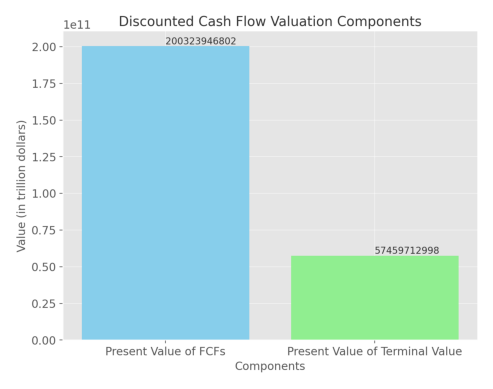

assistant:
The bar chart above visualizes the components of the discounted cash flow (DCF) valuation:

1. The first bar represents the **Present Value of Projected Free Cash Flows**, which is calculated from the discounted cash flows over the projection period (Total PV of FCFs).

2. The second bar shows the **Present Value of Terminal Value**, which is the discounted value at the end of the projection period, assuming a perpetual growth rate.

Note: For clarity and scale, the values are represented in trillion dollars on the chart, however, the actual values are the ones provided earlier in the analysis.



In [11]:
process_message("Visualize this information")

### Delete the thread and assistant

In [ ]:
for entity in [(client.beta.assistants, assistant), (client.beta.threads, thread)]:
    entity[0].delete(entity[1].id)

for file in assistant_files:
    client.files.delete(file.id)